# Download Raw Data

In [1]:
!gdown https://drive.google.com/uc?id=1Y6GtFq3VPyV_AUMm7OqCfhCZZuEelvRd

Downloading...
From: https://drive.google.com/uc?id=1Y6GtFq3VPyV_AUMm7OqCfhCZZuEelvRd
To: /content/threat_carrying_keypoints.zip
100% 928k/928k [00:00<00:00, 156MB/s]


In [2]:
!unzip -q threat_carrying_keypoints.zip

In [3]:
!pip install tensorflow==1.15.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 1.1 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 20.1 MB 84.8 MB/s 
     |████████████████████████████████| 3.8 MB 70.0 MB/s 
     |████████████████████████████████| 503 kB 53.6 MB/s 
     |████████████████████████████████| 2.9 MB 80.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=8d005e5e629bd188aab2b25f32cb6ab7e3deafe1c10b1eb56b107b4f9b2911d9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully unins

# Create Dataset

In [4]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

mainList = []
for root, dirs, files in os.walk('/content/output_jsons'):
  for name in files:
    if name.endswith('.json'):
      with open(os.path.join(root, name), 'r') as f:
        data = json.load(f)

      for person in data['people']:
        mainList.append((root.split('/')[3], person['pose_keypoints_2d']))

In [5]:
import random

def train_test_split(array):
  x = [c[0] for c in array]
  y = [e[1] for e in array]

  return x, y

random.shuffle(mainList)
split = int(len(mainList) * 0.7)
x_train, y_train = train_test_split(mainList[:split])
x_test, y_test = train_test_split(mainList[split:])

np.array(x_train).shape, np.array(y_train).shape, np.array(x_test).shape, np.array(y_test).shape

((661,), (661, 75), (284,), (284, 75))

In [6]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels = one_hot_encoder.fit_transform(np.array(x_train).reshape(-1, 1))
test_labels = one_hot_encoder.fit_transform(np.array(x_test).reshape(-1, 1))

train_labels.shape, test_labels.shape

((661, 2), (284, 2))

In [7]:
trainingSet = tf.data.Dataset.from_tensor_slices((y_train, train_labels)).batch(32)
validationSet = tf.data.Dataset.from_tensor_slices((y_test, test_labels)).batch(32)

# Modelling Predictions

In [8]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(75), dtype=tf.float32)

x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.6)(x)

outputs = layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/best_weights",
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["categorical_accuracy"])

history = model.fit(
    trainingSet,
    epochs=50,
    validation_data=validationSet,
    callbacks=[model_checkpoint_callback]
)

model.load_weights("/content/best_weights")

Epoch 1/50


21/21 [==============================] - 2s 117ms/step - loss: 15.8066 - categorical_accuracy: 0.5764 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 2.7353 - categorical_accuracy: 0.6354 - val_loss: 1.4443 - val_categorical_accuracy: 0.6901
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 1.4218 - categorical_accuracy: 0.6369 - val_loss: 1.0349 - val_categorical_accuracy: 0.7077
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 0.9691 - categorical_accuracy: 0.6309 - val_loss: 0.7542 - val_categorical_accuracy: 0.6479
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 0.6931 - categorical_accuracy: 0.6399 - val_loss: 0.7190 - val_categorical_accuracy: 0.6796
Epoch 6/50
21/21 [==============================] - 0s 3ms/step - loss: 0.6116 - categorical_accuracy: 0.6490 - val_loss: 0.6855 - val_categorical_accuracy: 0.6725
Epoch 7/50
21/21

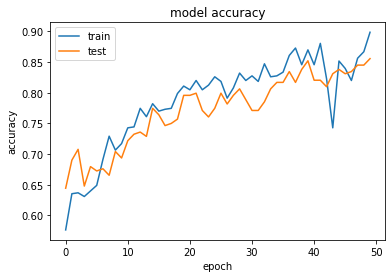

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

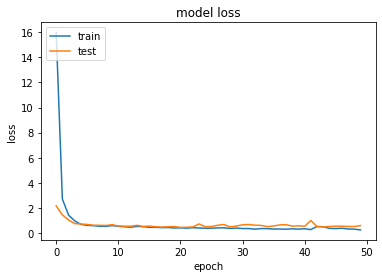

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
prediction_probability = model.predict(validationSet)
chosen_classes = tf.argmax(prediction_probability, axis=1)
labels = ["Threat" if idx == 1 else "Carrying" for idx in chosen_classes]

model.evaluate(validationSet)

9/9 [==============================] - 0s 1ms/step - loss: 0.5951 - categorical_accuracy: 0.8556


[0.5951245642370648, 0.8556338]

In [13]:
 from sklearn import metrics
 metrics.confusion_matrix(x_test, labels)

array([[146,   0],
       [138,   0]])

In [14]:
model.save("/content/pose_estimator.h5")